In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [2]:
#Leitura dos dados e verificação dos cabeçalhos e 2 primeiras linhas
df=pd.read_excel('DADOS_TESTE_R02.xlsx',usecols='B:U',skiprows=1)
df.head(2)

,Exp,Temp Med (°C),Temp Min (°C),Temp Max (°C),Temp Dpad,Precip Acum Mensal (mm),UR Med (%),UR. Min. (%),UR. Max. (%),UR Dpad,Vento Med (m/s),Vento Min (m/s),Vento Max (m/s),Vento Dpad,Direção Pred. Vento (°),Terral0|Maral1,Dist Mar (m),Outra Fonte (N0|S1),Densi. Obstáculos (0|1|2),Dep Cl (mg/m²)
0,VER,26.45,22.6,30.3,3.85,110.0,84.254672,70.250000,87.5,8.625000,4.845013,1.173696,8.516331,3.671317,90.0,1,35,0,1,523.34
1,OUT,21.25,16.9,25.6,4.35,49.0,77.646633,71.993267,83.3,5.653367,4.542106,0.487919,8.596294,4.054187,45.0,1,35,0,1,404.07


#### Exploração dos dados

In [6]:
#Verificação dos tipos de dados
df.dtypes

Exp                           object
Temp Med (°C)                float64
Temp Min (°C)                float64
Temp Max (°C)                float64
Temp Dpad                    float64
Precip Acum Mensal (mm)      float64
UR Med (%)                   float64
UR. Min. (%)                 float64
UR. Max. (%)                 float64
UR Dpad                      float64
Vento Med (m/s)              float64
Vento Min (m/s)              float64
Vento Max (m/s)              float64
Vento Dpad                   float64
Direção Pred. Vento (°)      float64
Terral0|Maral1                 int64
Dist Mar (m)                   int64
Outra Fonte (N0|S1)            int64
Densi. Obstáculos (0|1|2)      int64
Dep Cl (mg/m²)                object
dtype: object

In [8]:
#Tem algo estranho com os dados de deposição, já que deveria ser do tipo float.

In [10]:
#Converte os nomes dos meses do ano em números, com base nas estações do ano: verão-1, outono-2, inverno-3, primavera-4
df_cp=df.copy()  #Cria uma copia para evitar erros
dict_mes = {
    'JAN': 1, 'FEV': 1, 'MAR': 2, 'ABR': 2, 'MAI': 2, 'JUN': 3, 
    'JUL': 3, 'AGO': 3, 'SET': 4, 'OUT': 4, 'NOV': 4, 'DEZ': 1,
    'VER':1,'OUT':2,'INV':3,'PRI':4    
}
df_cp['Exp'] = df_cp['Exp'].map(dict_mes)     
df_cp['Exp'].head(5)

0    1
1    2
2    3
3    4
4    1
Name: Exp, dtype: int64

In [12]:
#Verificacao de dados faltantes:
df_cp.isnull().mean()*100

Exp                          0.000000
Temp Med (°C)                0.000000
Temp Min (°C)                0.000000
Temp Max (°C)                0.000000
Temp Dpad                    0.000000
Precip Acum Mensal (mm)      0.000000
UR Med (%)                   0.000000
UR. Min. (%)                 0.000000
UR. Max. (%)                 0.000000
UR Dpad                      0.000000
Vento Med (m/s)              0.000000
Vento Min (m/s)              0.000000
Vento Max (m/s)              0.000000
Vento Dpad                   0.000000
Direção Pred. Vento (°)      0.000000
Terral0|Maral1               0.000000
Dist Mar (m)                 0.000000
Outra Fonte (N0|S1)          0.000000
Densi. Obstáculos (0|1|2)    0.000000
Dep Cl (mg/m²)               0.342466
dtype: float64

In [14]:
#Como pode ser visto acima, existem dados faltantes na variável target. Como a quantidade é pequena, estes serão eliminados.
#1 - elimina linhas com dados faltantes
df_cp=df_cp.dropna()
#2 -Elimina linhas que estão preenchidas com strings na coluna de deposição de cloreto (target):
df_cp =df_cp[~df_cp.iloc[:,-1].apply(lambda x: isinstance(x, str))]

In [16]:
df_cp.isnull().mean()*100

Exp                          0.0
Temp Med (°C)                0.0
Temp Min (°C)                0.0
Temp Max (°C)                0.0
Temp Dpad                    0.0
Precip Acum Mensal (mm)      0.0
UR Med (%)                   0.0
UR. Min. (%)                 0.0
UR. Max. (%)                 0.0
UR Dpad                      0.0
Vento Med (m/s)              0.0
Vento Min (m/s)              0.0
Vento Max (m/s)              0.0
Vento Dpad                   0.0
Direção Pred. Vento (°)      0.0
Terral0|Maral1               0.0
Dist Mar (m)                 0.0
Outra Fonte (N0|S1)          0.0
Densi. Obstáculos (0|1|2)    0.0
Dep Cl (mg/m²)               0.0
dtype: float64

In [18]:
#Convert os dados da última coluna para float
df_cp.iloc[:,-1]=df_cp.iloc[:,-1].astype(float)

In [20]:
#Verifica as estatisticas do dataframe
df_cp.describe()

,Exp,Temp Med (°C),Temp Min (°C),Temp Max (°C),Temp Dpad,Precip Acum Mensal (mm),UR Med (%),UR. Min. (%),UR. Max. (%),UR Dpad,Vento Med (m/s),Vento Min (m/s),Vento Max (m/s),Vento Dpad,Direção Pred. Vento (°),Terral0|Maral1,Dist Mar (m),Outra Fonte (N0|S1),Densi. Obstáculos (0|1|2)
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.00000
mean,2.332117,26.550365,22.633577,30.467153,3.916788,76.664964,70.955012,68.010698,73.626277,2.807789,4.722709,2.546714,6.898704,1.360301,101.257299,0.529197,2107.992701,0.233577,1.60219
std,1.017750,1.334441,1.160162,2.027760,0.973735,96.985672,6.007017,5.446784,5.974320,1.432533,1.203635,0.768035,2.191860,0.961408,17.760836,0.500060,2470.922842,0.423880,0.68377
min,1.000000,21.250000,16.900000,22.200000,0.300000,2.200000,58.000000,55.000000,62.000000,1.250000,2.000000,0.487919,1.200000,0.400000,45.000000,0.000000,35.000000,0.000000,0.00000
25%,2.000000,26.475000,22.200000,30.500000,3.850000,8.200000,69.000000,67.000000,71.000000,2.000000,4.050000,1.900000,5.900000,0.937500,101.000000,0.000000,250.000000,0.000000,1.00000
50%,2.000000,26.750000,22.500000,31.200000,4.000000,10.800000,71.000000,68.000000,72.000000,2.500000,5.000000,2.800000,7.400000,1.150000,105.000000,1.000000,1000.000000,0.000000,2.00000
75%,3.000000,27.050000,23.500000,31.500000,4.450000,111.400000,76.000000,71.000000,78.000000,3.250000,5.787836,3.000000,8.512248,1.350000,108.000000,1.000000,4000.000000,0.000000,2.00000
max,4.000000,27.650000,23.800000,31.900000,4.850000,294.800000,84.254672,74.500000,87.500000,8.625000,6.100000,3.600000,10.225669,4.437833,123.500000,1.000000,8000.000000,1.000000,2.00000


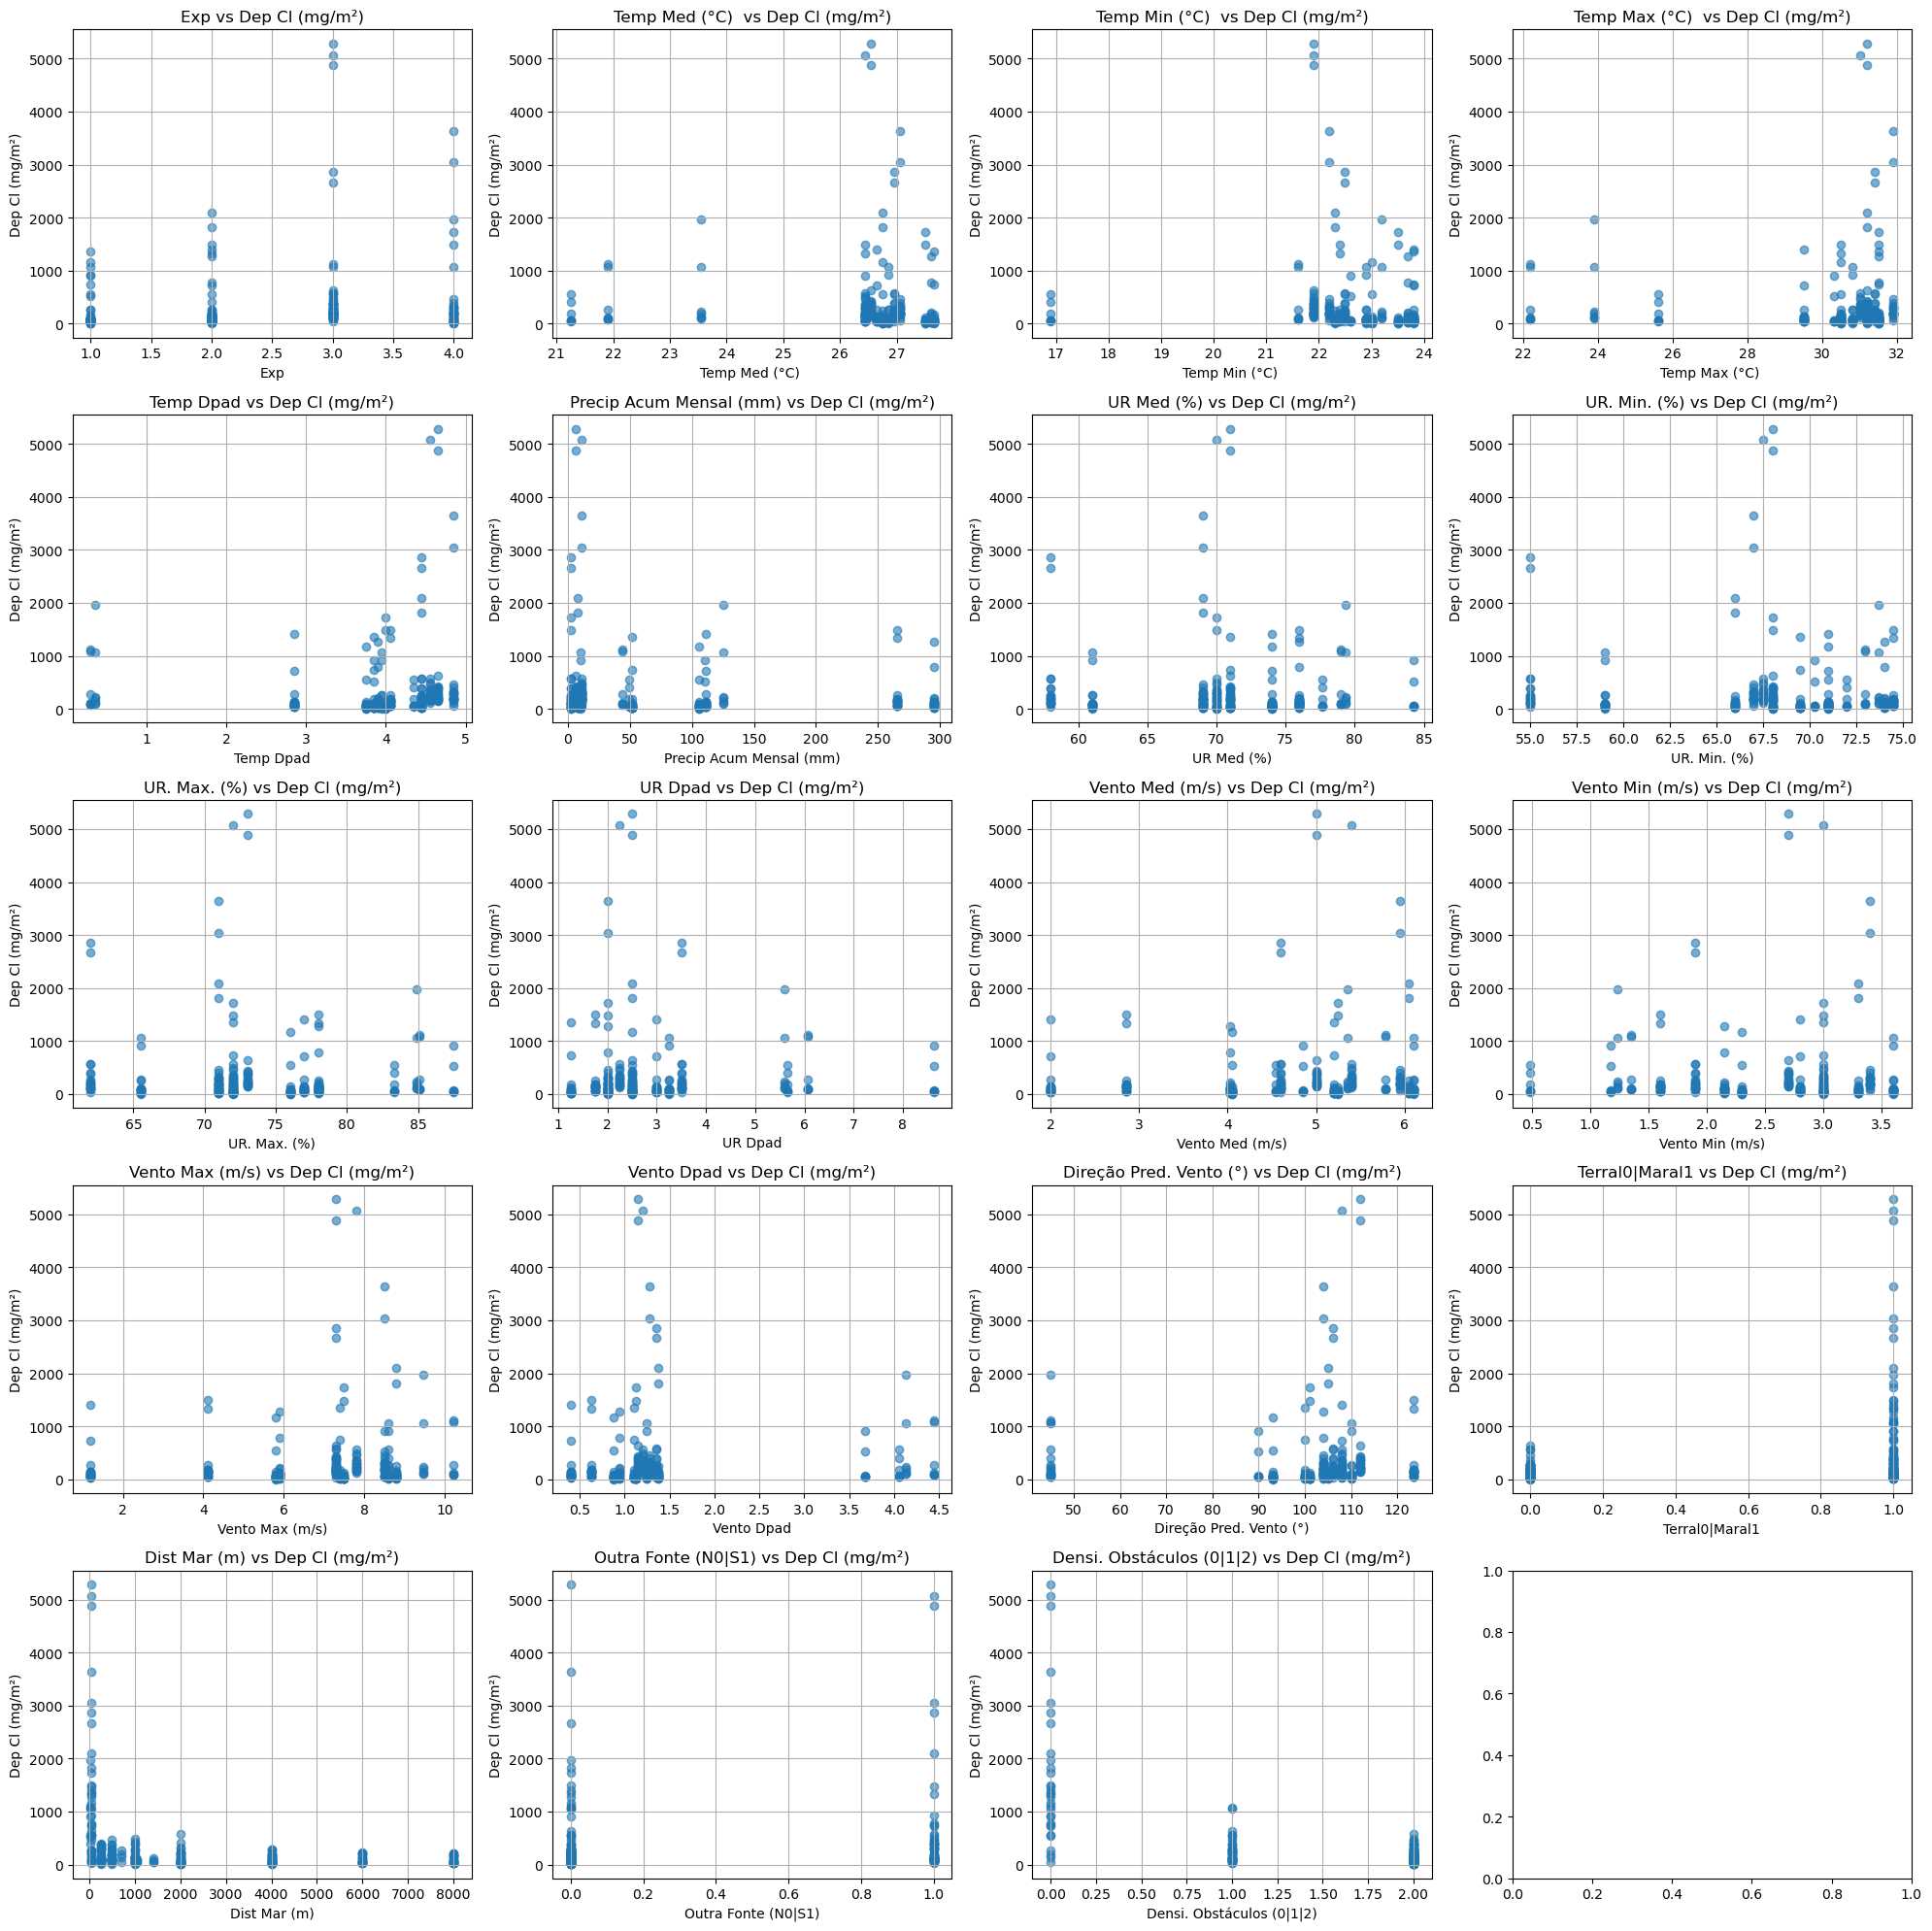

In [22]:
#Plot das relações entre variáveis independentes x target:
target = df_cp.columns[-1]
features = df_cp.columns[:-1]
n_cols = 4
n_rows = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(features):
    axes[i].scatter(df_cp[col], df_cp[target], alpha=0.6)
    axes[i].set_title(f"{col} vs {target}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

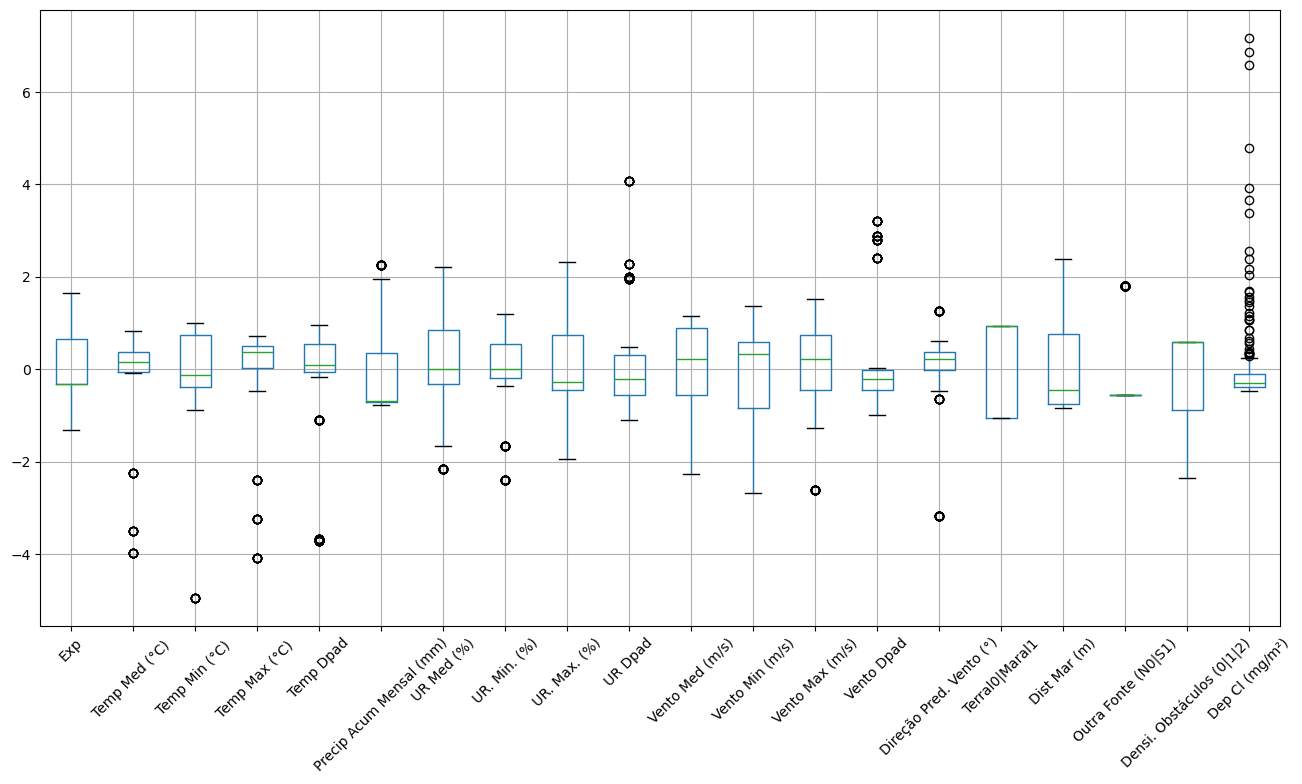

In [23]:
#Verificação de outliers em cada variável usando boxplots
std=StandardScaler()
scaler = StandardScaler()
temp=scaler.fit_transform(df_cp)
temp=pd.DataFrame(temp,columns=df_cp.columns)
#Plota o boxplot
plt.figure(figsize=(16,8))
temp.boxplot(rot=45)
plt.show()

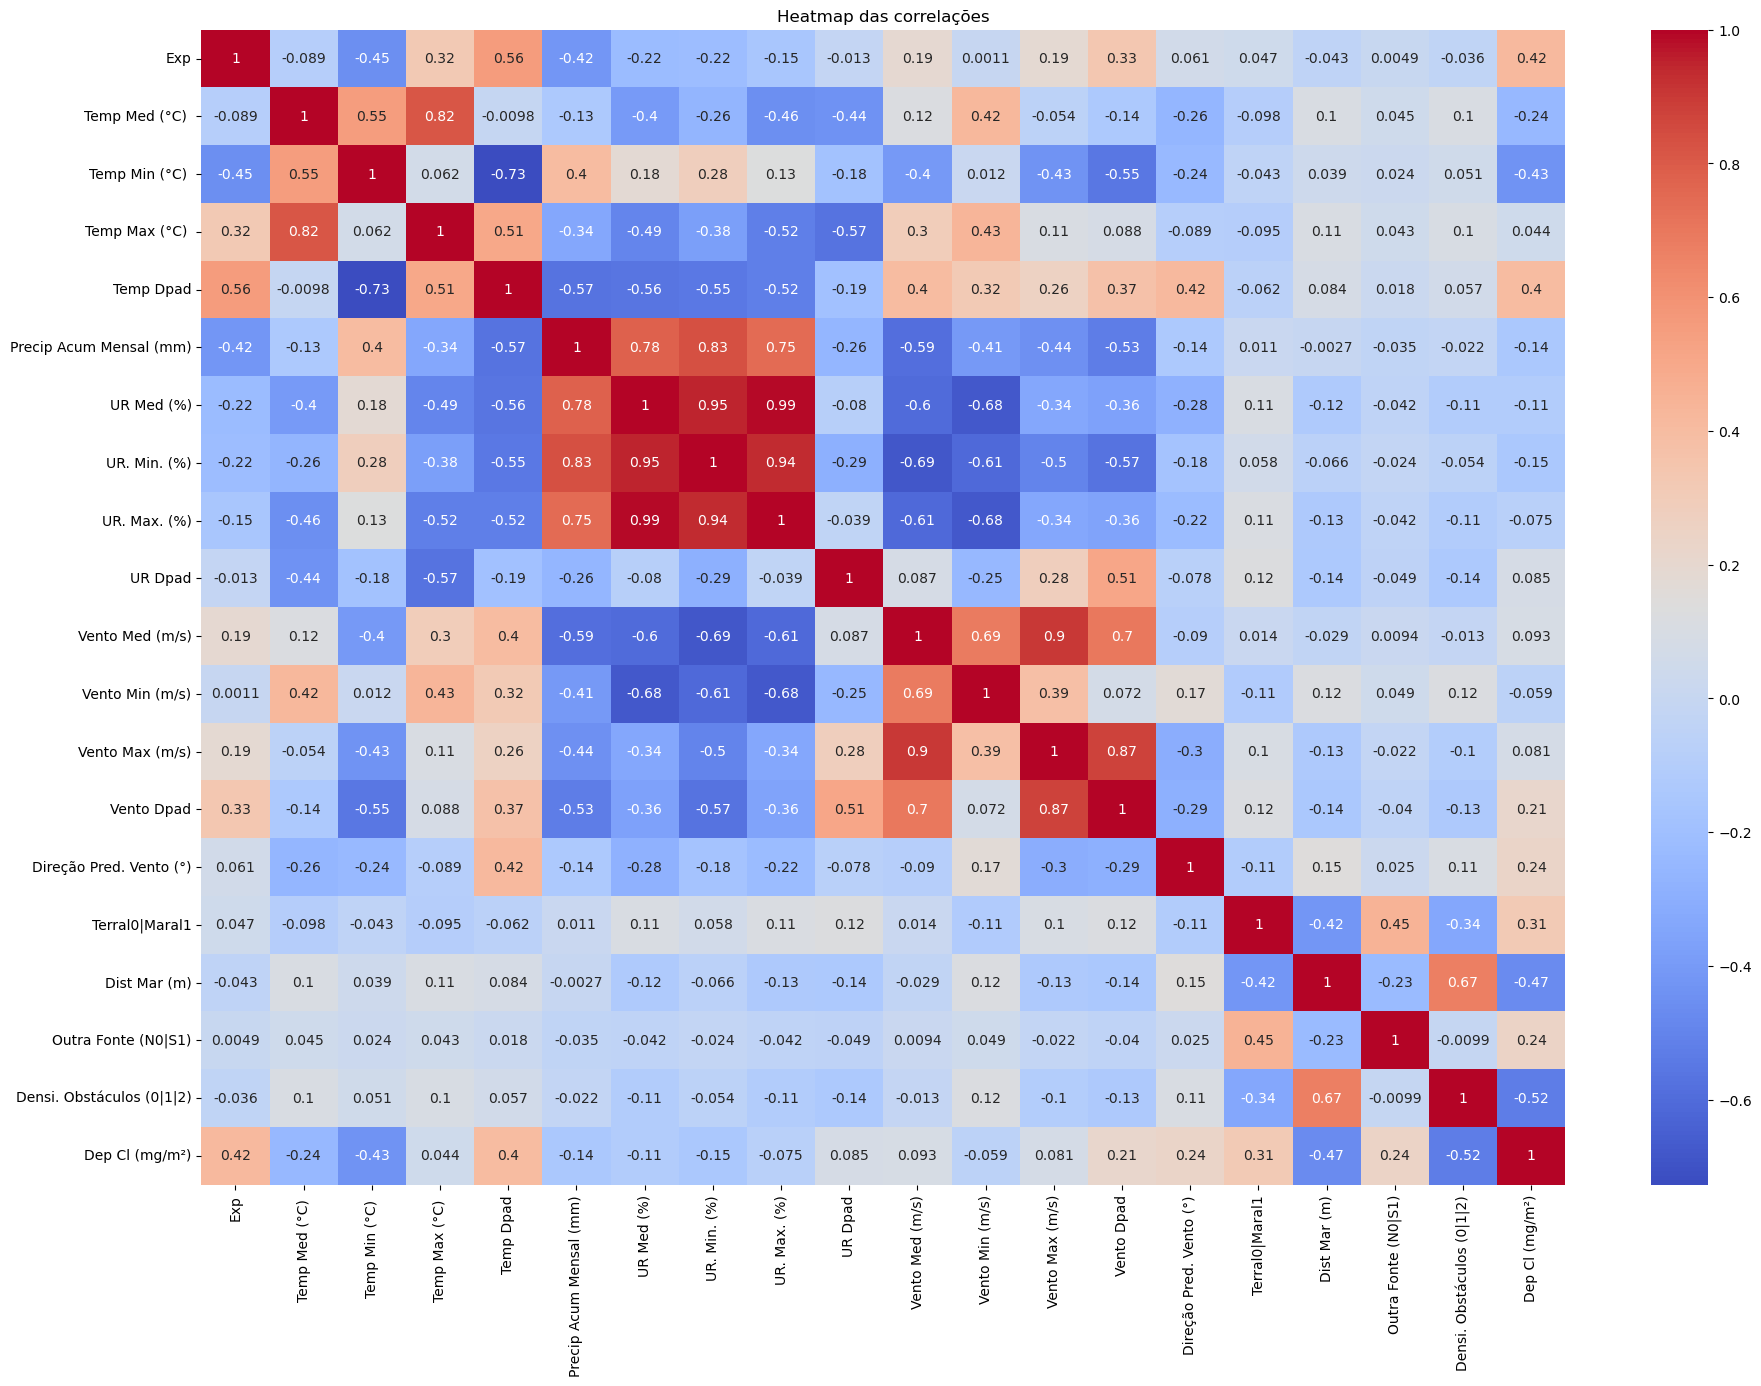

In [24]:
#Verificação das correlações:
corr=df_cp.corr(method='spearman')
plt.figure(figsize=(22,15))
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.title('Heatmap das correlações')
plt.show()

In [25]:
#Lista variáveis com correlação superior a 90%
corr_abs=corr.abs()
upper_triangle = np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
list_corr = corr_abs.where(upper_triangle).stack()
high_corr = list_corr[list_corr > 0.90].sort_values(ascending=False)
print(high_corr)

UR Med (%)       UR. Max. (%)       0.992104
                 UR. Min. (%)       0.950436
UR. Min. (%)     UR. Max. (%)       0.937843
Vento Med (m/s)  Vento Max (m/s)    0.901067
dtype: float64


Melhor número de atributos: 11
Atributos selecionados: ['Exp', 'Temp Dpad', 'Precip Acum Mensal (mm)', 'UR Med (%)', 'UR. Min. (%)', 'Vento Dpad', 'Direção Pred. Vento (°)', 'Terral0|Maral1', 'Dist Mar (m)', 'Outra Fonte (N0|S1)', 'Densi. Obstáculos (0|1|2)']


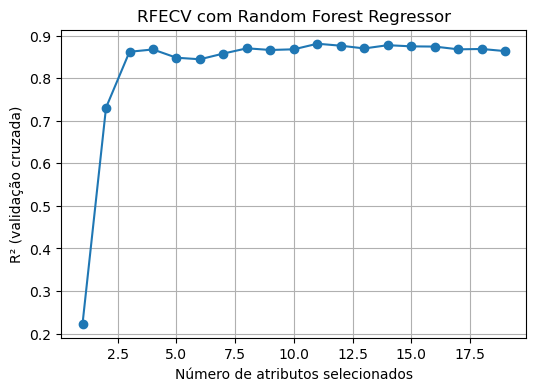

In [26]:
#Verificação das variáveis mais importantes com a eliminação recursiva de atributos (RFE):
def RFE(x,y):
    model=RandomForestRegressor(n_estimators=100, random_state=50)
    cv = KFold(n_splits=5, shuffle=True, random_state=50)
    rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='r2')
    rfecv.fit(x, y)
    # Exibe resultados
    print(f"Melhor número de atributos: {rfecv.n_features_}")
    print("Atributos selecionados:", x.columns[rfecv.support_].tolist())
    # Plot do desempenho
    plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), 
             rfecv.cv_results_["mean_test_score"], marker='o')
    plt.xlabel("Número de atributos selecionados")
    plt.ylabel("R² (validação cruzada)")
    plt.title("RFECV com Random Forest Regressor")
    plt.grid(True)
    plt.show()
fig,ax=plt.subplots(figsize=(6,4))
x=df_cp.iloc[:,:-1]
y=df_cp.iloc[:,-1]
RFE(x,y)

In [27]:
# O dataframe poderia ser reduzido, considerando apenas os atributos selecionados acima.
#Primeiro, eliminação dos dados com correlações acima de 90%:
corr = df_cp.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(to_drop)
df_filt = df_cp.drop(columns=to_drop)

['Temp Max (°C) ', 'UR. Min. (%)', 'UR. Max. (%)', 'Vento Max (m/s)']


In [30]:
df_cp.describe()

,Exp,Temp Med (°C),Temp Min (°C),Temp Max (°C),Temp Dpad,Precip Acum Mensal (mm),UR Med (%),UR. Min. (%),UR. Max. (%),UR Dpad,Vento Med (m/s),Vento Min (m/s),Vento Max (m/s),Vento Dpad,Direção Pred. Vento (°),Terral0|Maral1,Dist Mar (m),Outra Fonte (N0|S1),Densi. Obstáculos (0|1|2)
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.00000
mean,2.332117,26.550365,22.633577,30.467153,3.916788,76.664964,70.955012,68.010698,73.626277,2.807789,4.722709,2.546714,6.898704,1.360301,101.257299,0.529197,2107.992701,0.233577,1.60219
std,1.017750,1.334441,1.160162,2.027760,0.973735,96.985672,6.007017,5.446784,5.974320,1.432533,1.203635,0.768035,2.191860,0.961408,17.760836,0.500060,2470.922842,0.423880,0.68377
min,1.000000,21.250000,16.900000,22.200000,0.300000,2.200000,58.000000,55.000000,62.000000,1.250000,2.000000,0.487919,1.200000,0.400000,45.000000,0.000000,35.000000,0.000000,0.00000
25%,2.000000,26.475000,22.200000,30.500000,3.850000,8.200000,69.000000,67.000000,71.000000,2.000000,4.050000,1.900000,5.900000,0.937500,101.000000,0.000000,250.000000,0.000000,1.00000
50%,2.000000,26.750000,22.500000,31.200000,4.000000,10.800000,71.000000,68.000000,72.000000,2.500000,5.000000,2.800000,7.400000,1.150000,105.000000,1.000000,1000.000000,0.000000,2.00000
75%,3.000000,27.050000,23.500000,31.500000,4.450000,111.400000,76.000000,71.000000,78.000000,3.250000,5.787836,3.000000,8.512248,1.350000,108.000000,1.000000,4000.000000,0.000000,2.00000
max,4.000000,27.650000,23.800000,31.900000,4.850000,294.800000,84.254672,74.500000,87.500000,8.625000,6.100000,3.600000,10.225669,4.437833,123.500000,1.000000,8000.000000,1.000000,2.00000


Melhor número de atributos: 11
Atributos selecionados: ['Exp', 'Temp Dpad', 'Precip Acum Mensal (mm)', 'UR Med (%)', 'Vento Min (m/s)', 'Vento Dpad', 'Direção Pred. Vento (°)', 'Terral0|Maral1', 'Dist Mar (m)', 'Outra Fonte (N0|S1)', 'Densi. Obstáculos (0|1|2)']


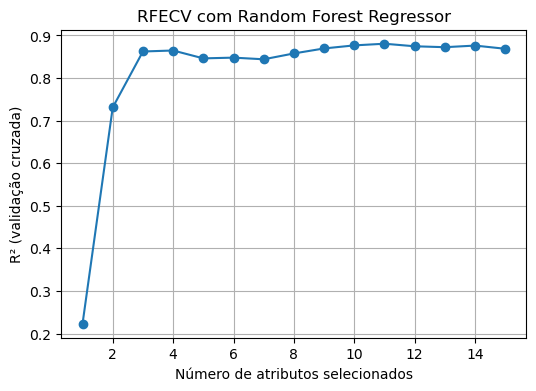

In [31]:
#Rodando novamente a eliminação recursiva de atributos após a remoção das variavéis com alta correlação:
fig,ax=plt.subplots(figsize=(6,4))
x=df_filt.iloc[:,:-1]
y=df_filt.iloc[:,-1]
RFE(x,y)

In [34]:
#Novo filtro no dataframe, selecionando as colunas listadas pelo RFE:
cols=['Exp', 'Temp Min (°C) ', 'Temp Dpad', 'Precip Acum Mensal (mm)', 'UR Med (%)', 'Vento Dpad', 'Direção Pred. Vento (°)', 
      'Terral0|Maral1', 'Dist Mar (m)', 'Outra Fonte (N0|S1)', 'Densi. Obstáculos (0|1|2)','Dep Cl (mg/m²)']
df_filt2=df_filt[cols].copy()
df_filt2.head(2)

,Exp,Temp Min (°C),Temp Dpad,Precip Acum Mensal (mm),UR Med (%),Vento Dpad,Direção Pred. Vento (°),Terral0|Maral1,Dist Mar (m),Outra Fonte (N0|S1),Densi. Obstáculos (0|1|2),Dep Cl (mg/m²)
0,1,22.6,3.85,110.0,84.254672,3.671317,90.0,1,35,0,1,523.34
1,2,16.9,4.35,49.0,77.646633,4.054187,45.0,1,35,0,1,404.07
